### Get the Personalize boto3 Client

All of the code that we are using in this lab is Python, but any langugage supported by SageMaker could be used. In this initial piece of code we are loading in the library dependencies that we need for the rest of the lab:

- *boto3* - standard Pything CLI library for the AWS SDK
- *json* - used to manipulate JSON structures used by our API calls
- *numpy* and *pandas* - standard libraries used by Data Scientists everywhere
- *time*, *datetime* and *pytz* - used for some time manipulation calls

These client handlers will be used throughout the lab, and you will see examples of other client handlers being instantiated for services such as Amazon S3 and IAM.  For ease of repeat use, we are storing some variables as we go along, as that we you can come back and skip the lengthy model creation cells and go straight to forecasting.

In [ ]:
%store

In [ ]:
import boto3

import json
import numpy as np
import pandas as pd
import time
import pytz
from datetime import datetime
from dateutil.parser import parse

forecast = boto3.client(service_name='forecast') 
forecastquery = boto3.client(service_name='forecastquery')

Calculation of the timestamp - easily done, but check on how your data actually calculates the week number - there are different methods out there, so make sure you choose the right one.  For now we'll just go with the first Monday.

In [ ]:
d = "201536"
r = datetime.strptime(d + '-1', "%Y%W-%w")
print(r)

Now we see how to get a date from this then, assuming that Monday is the first day of the week (the "-1" part) then we can apply it to the whole dataframe.

In [ ]:
df = pd.read_csv("WeeklySalesData_FY16-FY18.csv")
df['timestamp'] = pd.to_datetime(df['Cal Year'].<= '2018-08-20'
                               + df['Cal Week'].astype(str).add('-1') ,format='%Y%W-%w')
df

Now drop the columns that we don't need.  Other than the Timestamp value that we just created, we need the other fields that Forecast needs for a RETAIL domain Predictor, namely:

- item_id <- "Item SKU"
- demand <- "Units Sold"
- location <- "Store Code"

So we drop the other columns first, then rename the rest.

In [ ]:
df = df.drop(['Financial Year', 'Cal Year', 'Cal Week', 'Region', 'Location', 'Item Name'], axis=1)
df = df.rename(columns={"Store Code": "location", "Item SKU": "item_id",
                        "Units Sold": "demand"})
df

Now we have the parsed dataset.  Split the dataset based upon timestamp into two files - training and test - with out test set being just 3 months of whole 3 years worth of data.  We could just train on a subset of the data, but we're going to use all of it.  Note, we're stripping out the header row from the output files, as the Amazon Forecast documentation recommends that we do so.

In [ ]:
training_set = df[(df['timestamp'] >= '2015-03-01') & (df['timestamp'] <= '2018-05-31')]
test_set = df[(df['timestamp'] >= '2018-06-01') & (df['timestamp'] <= '2018-08-31')]

training_set.to_csv("item-demand-train.csv", header=False, index=False)
test_set.to_csv("item-demand-validation.csv", header=False, index=False)

### Specify a Bucket for Our Data

Amazon Forecast only supports the uploading of data from an S3 bucket. Hence, you need to create a new bucket or re-use an existing one. If you need to create one the you *MUST* name your bucket before running this Code cell by editing the value for bucket in the code below. You need to ensure that the bucket name is globally unique; for this lab we recommend using your name or initials, followed by -forecast-retail-data, as that is likely to be unique

If the bucket already exists - such as if you execute this code cell a second time - then it will not create a new bucket, and will not make any changes to the existing bucket. If this happens unexpectedly then please check your own S3 page in the console to ensure that the bucket is in your account.



In [ ]:
bucket_name = "ajk-forecast-retail-data"           # replace with the name of your S3 bucket

s3 = boto3.client('s3')
if boto3.resource('s3').Bucket(bucket_name).creation_date is None:
    s3.create_bucket(ACL = "private", Bucket = bucket_name, CreateBucketConfiguration={
        'LocationConstraint': 'eu-west-1'})
    print("Creating bucket: {}".format(bucket_name))
else:
    print("Bucket {} already exists".format(bucket_name))

Now we have our bucket, we can upload our training file to S3

In [ ]:
key="data/item-demand-train.csv"

boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file("item-demand-train.csv")

## Creating the Dataset Group and Dataset 

In Amazon Forecast, a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast.

More details about Domain and dataset type can be found on the documentation. For this example, we are using RETAIL domain with 3 required attributes: timestamp, demand and item_id.  We're also going to add in a recommended optional field, location, as our dataset consists of multiple store locations and we want to be able to forecast for each one.

It is important to also convey how Amazon Forecast can understand your time-series information. That the cell immediately below does that, defining a weekly dataset and a specific timestamp format, and the next one then configures your variable names for the Project, DatasetGroup, and Dataset.

In [ ]:
DATASET_FREQUENCY = "W" 
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [ ]:
project = 'retail_food_forecastdemo'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucket_name+"/"+key

### Create Dataset Group

In [ ]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="RETAIL",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)
%store datasetGroupArn

### Create the Schema

We now specify the schema, which tells Forecat how to parse the data.  This is the order of our training set columns, and we must ensure that these match the schema.

In [ ]:
schema = {
     "Attributes": [
        {
           "AttributeName": "location",
           "AttributeType": "string"
        },
        {
           "AttributeName": "item_id",
           "AttributeType": "string"
        },
        {
           "AttributeName": "demand",
           "AttributeType": "float"
        },
        {
           "AttributeName": "timestamp",
           "AttributeType": "timestamp"
        }
    ]
}

### Create the Dataset

In [ ]:
response=forecast.create_dataset(
                    Domain="RETAIL",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)
%store datasetArn

### Add Dataset to Dataset Group

In [ ]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

### Create IAM Role for Forecast
Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. The code below will create the role and it will be used later for accessing your data in S3.

In [ ]:
iam = boto3.client("iam")
role_name = "ForecastRoleRetailDemo"

try:
    role_arn = iam.get_role(RoleName = role_name)["Role"]['Arn']
    print ("Role alread exists: ", role_arn)
except:
    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
              "Effect": "Allow",
              "Principal": {
                "Service": "forecast.amazonaws.com"
              },
              "Action": "sts:AssumeRole"
            }
        ]
    }

    create_role_response = iam.create_role(
        RoleName = role_name,
        AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
    )

    # AmazonForecastFullAccess gives our role everything it needs to call itself
    policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
    iam.attach_role_policy(
        RoleName = role_name,
        PolicyArn = policy_arn
    )

    # Now add S3 support, and for here we're just going for full access
    iam.attach_role_policy(
        PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
        RoleName=role_name
    )
    time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

    role_arn = create_role_response["Role"]["Arn"]
    print("New role created: ", role_arn)

### Create Data Import Job

Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecaast.

In [ ]:
datasetImportJobName = 'FOOD_STORE_DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

Check the status of dataset, when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on the data size. It can take between 3 and 10 mins to be **ACTIVE**.

In [ ]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)
    
    dataset_import_job = dataImportStatus["DatasetImportJobName"]
    now = datetime.now(pytz.utc)
    elapsed = now - dataImportStatus["CreationTime"]
    if "latestDatasetImportJobRun" not in dataImportStatus:
        status = dataImportStatus["Status"]
        print("DatasetImportJob: {}   (elapsed = {})".format(status, elapsed))
    else:
        # Not sure if this happens in Forecasr
        status = dataImportStatus["latestDatasetImportJobRun"]["Status"]
        print("LatestDatasetImportJobRun: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

### Create a Predictor

Here we will once again define your dataset information and then start building your model or predictor.

Forecast horizon is the number of number of time points to predicted in the future. For weekly data, a value of 13 means 13 weeks, which is what we want to forecast. Our example is weekly data, and we want to try and predict up to 13 weeks ahead.  We are going to use DeepAR+, as our dataset is actually fully populated with no gaps - if it was sparsely populated then we'd have considered NPTS, and if it was in the middle we'd have tried Prophet.

Of course, you could have left AutoML to do its job, but that takes more time, and in this case it would have returned DeepAR+, but I suggest you play around with some HPO to further optimise the accuracy of the results, as well as extending the backtest window to more and/or longer windows.

In [ ]:
predictorName= project+'_deeparp_algo'
forecastHorizon = 13
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

In [ ]:
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                      AlgorithmArn=algorithmArn,
                                      ForecastHorizon=forecastHorizon,
                                      PerformAutoML=False,
                                      PerformHPO=False,
                                      EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                             "BackTestWindowOffset": 13}, 
                                      InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                      FeaturizationConfig= {"ForecastFrequency": "W",
                                                            "ForecastDimensions": ["location"]}
                                     )

In [ ]:
predictor_arn=create_predictor_response['PredictorArn']
%store predictor_arn

Check the status of the predictor. When the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on data size, model selection and hyper parameters，it can take 10 mins to more than one hour to be **ACTIVE**.

In [ ]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    predictorStatus = forecast.describe_predictor(PredictorArn=predictor_arn)
    now = datetime.now(pytz.utc)
    elapsed = now - predictorStatus["CreationTime"]
    status = predictorStatus["Status"]
    print("CreatePredictor: {}   (elapsed = {})".format(status, elapsed))

    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(30)

### Create a Forecast

Now create a forecast using the model that was trained

In [ ]:
forecastName = project+'_deeparp_algo_forecast'
create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
                                                  PredictorArn=predictor_arn)
forecast_arn = create_forecast_response['ForecastArn']
%store forecast_arn

Check the status of the forecast process, when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on data size, model selection and hyper parameters，it can take 10 mins to more than one hour to be **ACTIVE**.

In [ ]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    forecastStatus = forecast.describe_forecast(ForecastArn=forecast_arn)
    now = datetime.now(pytz.utc)
    elapsed = now - forecastStatus["CreationTime"]
    status = forecastStatus["Status"]
    print("CreateForecast: {}   (elapsed = {})".format(status, elapsed))

    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(30)

### Get Forecast

Once created, the forecast results are ready and you query it for particular results - here we'll just go and see how well we forecasted one item across all stores, but we could always add **location** to the *Filters* to get a forecast for a specific location/item combination.  We can do this because when we created the Predictor we added in location as a specific dimension that we were interested in; if we hadn't done this at that time then you couldn't then query on location.

In [ ]:
itemToForecast = "30295920"

In [ ]:
print(forecast_arn)
print()
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": itemToForecast},
    StartDate="2018-06-04T00:00:00",
    EndDate="2018-08-20T00:00:00"
)
print(forecastResponse)

### Plotting the Actual Results
At the beginning of this notebook we created a file of observed values, we are now going to select a given date and customer from that dataframe and are going to plot the actual usage data for that customer.

In [ ]:
actual_df = pd.read_csv("item-demand-validation.csv", names=['location','item','demand', 'timestamp'])
actual_df.head()

Only grab values for item 30295920.  The single prediction forecast that we just did is only for a single *item_id*, so will return the totals across all stores for each weekly time slot.  Hence, to graph this properly with the actual values we need to summarise the actuals across all stores too.  If you changed the filter in the previous step to also forecast for locations then add the additional condition to the *item* and *timestamp* filter below.

In [ ]:
actual_df = actual_df[(actual_df['item'].astype(str) == itemToForecast) 
                   & (actual_df['timestamp'] <= '2018-08-20')]
actual_df = actual_df.drop(['item'], axis=1)
actual_df.head()

Now we group by timestamp and sum up the other fields - this sums the demand and the location fields, but by then dropping location we are left with a single row per timestamp, will a rolled-up demand across all locations.

In [ ]:
newdf = actual_df.groupby('timestamp').sum().drop('location', axis=1)
newdf

In [ ]:
newdf.plot()

### Plotting the Prediction

Next we need to convert the JSON response from the Predictor to a dataframe that we can plot - remember that this is a summary across all locations for this item if you did not add in the *location* filters.

In [ ]:
prediction_df_p10 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

In [ ]:
prediction_df_p10.plot()

The above merely did the p10 values, now do the same for p50 and p90.

In [ ]:
prediction_df_p50 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p90'])

### Comparing the Prediction to Actual Results

After obtaining the dataframes the next task is to plot them together to determine the best fit.  We start by creating a dataframe to house our content, and have a **source** colume to indicate which dataframe it came from

In [ ]:
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

Next, we import the observed values into the dataframe.

In [ ]:
for index, row in newdf.iterrows():
    clean_timestamp = parse(index)
    results_df = results_df.append({'timestamp' : clean_timestamp, 'value' : row['demand'], 'source': 'actual'},
                                   ignore_index=True)
results_df.head()

Now we add in the P10, P50, and P90 Values.

In [ ]:
for index, row in prediction_df_p10.iterrows():
    clean_timestamp = parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

In [ ]:
results_df

Pivot the whole table around the *source* and *timestamp* fields, which gives us a usable (and plottable) table.

In [ ]:
pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")
pivot_df

In [ ]:
pivot_df.plot()

## Full Forecast Export

To do any proper analysis of the results we really need to use a BI tool of some sort, so we will prepare a full export for our forecast horizon - this should give us all items for all store locations, which we can then look at in Excel, Quicksight or any other tool that can import CSV.

Check the status of the export job. When the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can launch our BI tool of choice and start exploring. This can take 2 mins to more than 10 minutes to be **ACTIVE** for this dataset.

In [ ]:
forecastExportName = project + '_forecast_export'
s3ExportPath = "s3://" + bucket_name + "/forecasts"
create_forecast_export_response=forecast.create_forecast_export_job(ForecastExportJobName=forecastExportName,
                                                             ForecastArn=forecast_arn,
                                                             Destination={
                                                                 'S3Config': {
                                                                     'Path': s3ExportPath,
                                                                     'RoleArn': role_arn
                                                                 }
                                                             }
                                                        )
forecastExport_arn = create_forecast_export_response['ForecastExportJobArn']
%store forecastExport_arn

In [ ]:
status = None
max_time = time.time() + 60*60 # 1 hour
while time.time() < max_time:
    forecastExportStatus = forecast.describe_forecast_export_job(ForecastExportJobArn=forecastExport_arn)
    now = datetime.now(pytz.utc)
    elapsed = now - forecastExportStatus["CreationTime"]
    status = forecastExportStatus["Status"]
    print("ForecastExportJob: {}   (elapsed = {})".format(status, elapsed))

    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(30)

### Merging Forecast with Known Demand

As before with the plot for a single item across all stores, we need to merge in the actual known values - that way we can visualise how accurate these forecasts actually were.  Note that we rename/reformat columns between our two dataframes for the sake of consistency, and sort the various *df.head()* outputs so that you can visually check that the correct values are being merged across.  Clearly, they are, but this helps you see that it really is doing what you think.  We start by reading in the actual demand values.

In [ ]:
actual_df = pd.read_csv("item-demand-validation.csv", names=['location','item_id','demand', 'date']).sort_values(by=['date', 'location', 'item_id'])
actual_df.head()

Next, load in generated forecast file - Note, export filename has timestamp-base suffix, so please go check the name in the S3 console.  Then, we change the date format to be the same as the date in the item validation frame for easy merging.

In [ ]:
exportS3Filename = s3ExportPath + "/" + forecastExportName + "_2019-12-03T00-01-48Z_part0.csv"  # CHANGE THIS NAME
exportDf = pd.read_csv(exportS3Filename).sort_values(by=['date', 'location', 'item_id'])

exportDf['date'] = pd.to_datetime(exportDf['date']).dt.strftime('%Y-%m-%d')
exportDf.head()

In [ ]:
newDF = pd.merge(exportDf, actual_df, on=['date', 'location', 'item_id']).sort_values(by=['date', 'location', 'item_id'])
newDF.head()

Now we have our single merged dataframe, we can write it back to S3 and start diving into it with our chosen tooling.  But first, due to some oddities with the demand values for the final week number - it looks like partial week figures, so let's just trim that off.

In [ ]:
newDF = newDF[(newDF['date'] <= '2018-08-20')]

newDF.to_csv("merged-forecast-with-actuals.csv", header=True, index=False)
key="forecasts/merged-forecast-with-actuals.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file("merged-forecast-with-actuals.csv")

### Evaluating the Results

Download the file "merged-forecast-with-actuals.csv" from the S3 bucket to your local machine, and open it with Excel.  From here, create a new pivot table with the whole dataset and put it in a new worksheet.  In order to properly view the forecasts we suggest that you use the following pivot settings:

- **Filters** - item_id and date
- **Rows** - date, but just the date and not any automatically-inserted Month field
- **Values** - demand (sum), p10 (sum), p50 (sum) and p90 (sum)

Once done, insert a pivot chart based upon a standard line chart.

This allows you to effectively show forecasts for any item/store combination, or pick out aggregates such as forecasts for a single SKU across multiple stores.  Once you're happy with this, save the spreadsheet as a standard .xlsx file and you can share your results with others.

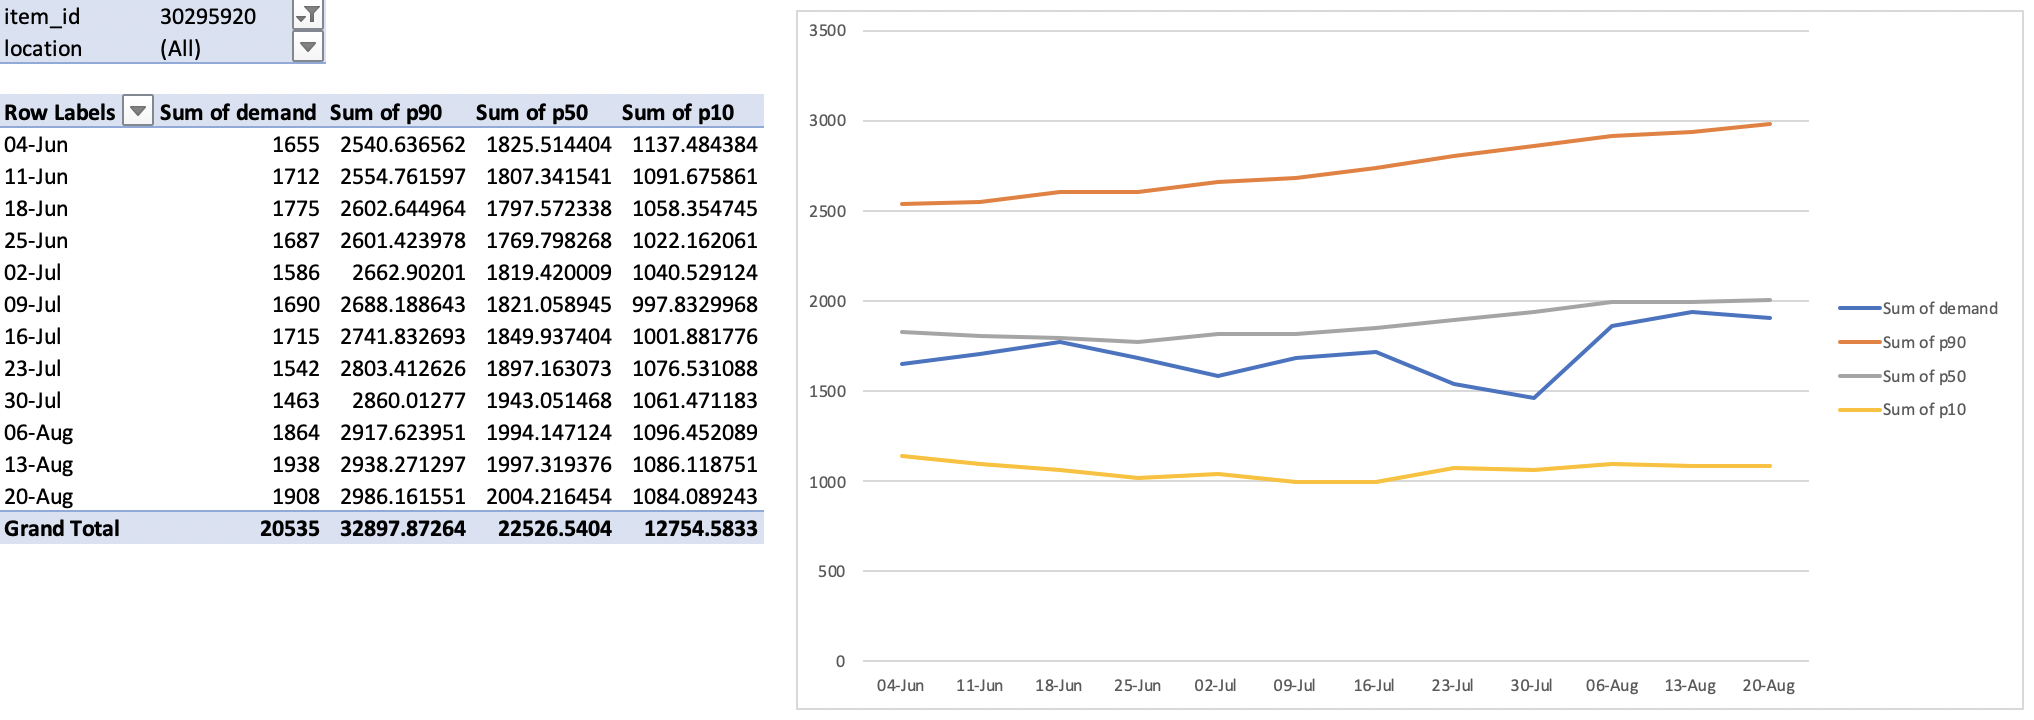